<h1> General Setup </h1>

<h3> Imports </h3>

In [1]:
import pygad
from read_data import read_dataset_1, translate_1
from models import SimulationEnvironment
import plotly.figure_factory as ff
import random
import copy

<h3> General Parameters </h3>

In [2]:
order_amount = 5
earliest_time_slot = 0
last_time_slot = 5000

#random.seed(1)

<h3> Load Data / Environment Setup </h3>

In [3]:
input, orders, instance = read_dataset_1(use_instance=13, order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_1(instance, orders, earliest_time_slot, last_time_slot)
env = SimulationEnvironment(workstations, tasks, resources, recipes)

<h3> Visualization Code </h3>

In [4]:
def get_colors(n): 
    ret = [] 
    r = int(random.random() * 256) 
    g = int(random.random() * 256) 
    b = int(random.random() * 256) 
    step = 256 / n 
    for i in range(n): 
        r += step 
        g += step 
        b += step 
        r = int(r) % 256 
        g = int(g) % 256 
        b = int(b) % 256 
        ret.append((r,g,b))  
    return ret

def visualize(data):
    # data format: 0 - workstation, 1 - job id, 2 - start time, 3 - duration
    colors = {}
    rgb_values = get_colors(len(orders))
    for i in range(len(orders)):
        colors[str(f'Order {i}')] = f'rgb({rgb_values[i][0]}, {rgb_values[i][1]}, {rgb_values[i][2]})' # just ignore colors for now
    composed_data = []
    
    for i in range(len(data)):
        label = f'W{data[i][0]}'
        start = data[i][2]
        end = start + data[i][3]
        composed_data.append(
                    dict(Task=label, Start=start, Finish=end, Resource=f'Order {order_for_index[i]}')
                )
        #print(composed_data)
    fig = ff.create_gantt(composed_data, colors=colors, index_col='Resource', show_colorbar=True,
                        group_tasks=True, showgrid_x=True)
    fig.update_layout(xaxis_type='linear')
    """import plotly.express as px
    fig = px.timeline(composed_data, x_start='Start', x_end='Finish', y='Task', color='Resource')""" # for some reason doesn't do what it's supposed to do
    fig.show()

<h1> Optimizers </h1>

<h3> 2-Stage GA (PyGAD) </h3>

In [14]:
duration_lookup_table = dict()
for task in tasks:
    if not task.id in duration_lookup_table:
        duration_lookup_table[task.id] = dict()
    for workstation in env.get_valid_workstations(task.id):
        duration_lookup_table[task.id][workstation.id] = env.get_duration(task.id, workstation.id)

operations = []
order_for_index = []
for order in orders_model:
    for resource in order.resources:
        recipe = resource.recipes[0] # just use recipe 0 for now
        recipe_tasks = env.get_all_tasks_for_recipe(recipe.id)
        results = dict()
        for task in recipe_tasks:
            if task.result_resources[0][0] not in results:
                results[task.result_resources[0][0]] = []
            results[task.result_resources[0][0]].append(task)
        for key in results:
            operations.append(random.choice(results[key]).id)
            order_for_index.append(order.id)
assignments = []

for operation in operations:
    workstation = env.get_valid_workstations(operation)
    # random init
    assignments.append(random.choice(workstation).id)

def fitness_function(solution, solution_idx):
    bins = dict()
    sum = 0
    max_sum = 0
    for operation in list(duration_lookup_table.keys()):
        max = -float('inf')
        for workstation in list(duration_lookup_table[operation].keys()):
            if duration_lookup_table[operation][workstation] > max:
                max = duration_lookup_table[operation][workstation]
        max_sum += max
    for i in range(len(solution)):
        if solution[i] not in duration_lookup_table[operations[i]]: # illegal combination
            return len(solution) * 10000 * -1
        if i not in bins:
            bins[i] = 0
        sum += duration_lookup_table[operations[i]][solution[i]] # minimize working minutes for all workstations
        #bins[i] += duration_lookup_table[operations[i]][solution[i]]
    return sum * -1

def balance_fitness_function(solution, solution_idx):
    fitness = 0
    sums = dict()
    for i in range(len(workstations)):
        sums[i+1] = 0
    for i in range(len(solution)):
        if solution[i] not in duration_lookup_table[operations[i]]:
            return len(solution) * 100000 * -1
        if solution[i] not in sums:
            sums[solution[i]] = 0
        sums[solution[i]] += duration_lookup_table[operations[i]][solution[i]]
    for workstation in sums.keys():
        for other_workstation in sums.keys():
            fitness += abs(sums[workstation] - sums[other_workstation])
    return fitness *-1

def mutation_function(offsprings, ga_instance):
    for offspring in offsprings:
        p = 1 / len(offspring)
        for i in range(len(offspring)):
            if random.random() < p:
                offspring[i] = random.choice(list(duration_lookup_table[operations[i]].keys()))
    return offsprings

def on_fitness_assignemts(ga_instance, population_fitness):
    current_best = abs(sorted(population_fitness, reverse=True)[0]) - 1
    if len(assignments_best) == 0:
        assignments_best.append(current_best)
    elif current_best < assignments_best[len(assignments_best)-1]:
        assignments_best.append(current_best)
    else:
        assignments_best.append(assignments_best[len(assignments_best)-1])
    sum = 0
    for individual_fitness in population_fitness:
        sum += abs(individual_fitness)-1
    average_assignments.append(sum/len(population_fitness))

assignments_best = []
average_assignments = []
num_genes = len(assignments)
num_generations = 5000
num_parents_mating = 50
sol_per_pop = 100
init_range_low = 0
init_range_high = last_time_slot
parent_selection_type = 'rws'
keep_parents = 10
crossover_type = 'two_points'
mutation_type = mutation_function
#mutation_type = 'random'
mutation_percentage_genes = 10
fitness_func = fitness_function
#fitness_func = balance_fitness_function
gene_type = int
space_workstations = {'low': 1, 'high': len(workstations)-1}
gene_space = []
for i in range(len(assignments)):
    gene_space.append(space_workstations)
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, on_fitness=on_fitness_assignemts, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(solution_fitness) - 1))

def is_feasible(solution):
    for i in range(len(solution)):
        start = solution[i]
        end = start + duration_lookup_table[operations[i]][assignments[i]]
        if end > last_time_slot:
            return False
        if start < earliest_time_slot:
            return False
        # overlap
        same_workstation = [] # append indices of jobs running on the same workstation
        for j in range(len(assignments)):
            if assignments[j] == assignments[i] and i != j:
                same_workstation.append(j)
        for j in range(len(same_workstation)):
            other_start = solution[same_workstation[j]]
            other_end = other_start + duration_lookup_table[operations[same_workstation[j]]][assignments[same_workstation[j]]]
            if start > other_start and start < other_end:
                return False
            if end > other_start and end < other_end:
                return False
            if other_start > start and other_start < end:
                return False
            if other_end > start and other_end < end:
                return False
        # check sequence
        order = order_for_index[i]
        if i > 0:
            if order_for_index[i-1] == order: # same order
                prev_start = solution[i-1]
                prev_end = prev_start + duration_lookup_table[operations[i-1]][assignments[i-1]]
                if prev_end > start:
                    return False
    return True

def fitness_function_time_slots(solution, solution_idx):
    fitness = 1
    if not is_feasible(solution):
        #fitness += last_time_slot
        return -2 * last_time_slot
    max = -float('inf')
    min = float('inf')
    for i in range(len(solution)):
        start = solution[i]
        end = start + duration_lookup_table[operations[i]][assignments[i]]
        if start < min:
            min = start
        if end > max:
            max = end
    fitness += abs(max - min)
    return -fitness

def on_fitness(ga_instance, population_fitness):
    current_best = abs(sorted(population_fitness, reverse=True)[0]) - 1
    if len(time_best) == 0:
        time_best.append(current_best)
    elif current_best < time_best[len(time_best)-1]:
        time_best.append(current_best)
    else:
        time_best.append(time_best[len(time_best)-1])
    sum = 0
    for individual_fitness in population_fitness:
        sum += abs(individual_fitness)-1
    average_time.append(sum/len(population_fitness))

def mutation_function_time_slots(offsprings, ga_instance):
    for offspring in offsprings:
        p = 1 / len(offspring)
        for i in range(len(offspring)):
            if random.random() < p:
                offspring[i] = random.randint(earliest_time_slot, last_time_slot)
    return offsprings

time_best = []
average_time = []
assignments = solution
start_slots = []
for assignment in assignments:
    start_slots.append(0)
num_genes = len(start_slots)
num_generations = 5000
num_parents_mating = 50
sol_per_pop = 100
init_range_low = 0
init_range_high = last_time_slot
parent_selection_type = 'rws'
keep_parents = 10
crossover_type = 'two_points'
mutation_type = mutation_function_time_slots
#mutation_type = 'random'
mutation_percentage_genes = 10
fitness_func = fitness_function_time_slots
gene_type = int
space_time = {'low': earliest_time_slot, 'high': last_time_slot}
gene_space = []
for i in range(len(assignments)):
    gene_space.append(space_time)
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, on_fitness=on_fitness, fitness_func=fitness_func, sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high, parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type, mutation_type=mutation_type, mutation_percent_genes=mutation_percentage_genes, gene_type=gene_type, gene_space=gene_space)
ga_instance.run()
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=abs(solution_fitness) - 1))

Parameters of the best solution : [5 3 6 6 6 6 5 3 6 3 3 3 6 6 6]
Fitness value of the best solution = 1954
Parameters of the best solution : [2883 3861 4363 2129 2626 4115 2200 2959 3161 2177 3321 3428 2962 3596
 3979]
Fitness value of the best solution = 2339


In [15]:
data = []
for i in range(len(solution)):
    data.append([assignments[i], operations[i], solution[i], duration_lookup_table[operations[i]][assignments[i]]])
visualize(data)

In [16]:
def is_first(jobs, index): # check if job is the first in it's order sequence
    return jobs[index][2] == 0 or order_for_index[jobs[index][2]-1] != order_for_index[jobs[index][2]]
durations = []
for i in range(len(assignments)):
    durations.append(duration_lookup_table[operations[i]][assignments[i]])

w = dict()
for i in range(len(assignments)):
    if assignments[i] not in w:
        w[assignments[i]] = []
    w[assignments[i]].append([solution[i], solution[i]+durations[i], i]) #<start, end, index>
import copy
new_solution = copy.deepcopy(solution)
changes_made = True
while changes_made:
    changes_made = False
    for workstation in w.keys():
        sorted_jobs = sorted(w[workstation], key=lambda x: x[0])
        for i in range(len(sorted_jobs)):
            shift = 0
            if is_first(sorted_jobs, i):
                if i == 0: # start at 0
                    shift = sorted_jobs[i][0] 
                    sorted_jobs[i][0] -= shift
                    sorted_jobs[i][1] -= shift                  
                else: # there are other jobs on this workstation before this one
                    shift = sorted_jobs[i][0] - sorted_jobs[i-1][1] # move it back to where the previous job stopped
                    sorted_jobs[i][0] -= shift
                    sorted_jobs[i][1] -= shift
            else: # find end of previous job in sequence + end of job previous on the workstation -> move to closer one
                prev_end = new_solution[sorted_jobs[i][2]-1] + durations[sorted_jobs[i][2]-1]
                prev_shift = sorted_jobs[i][0] - prev_end
                if i == 0: # no previous jobs on this workstation
                    shift = prev_shift
                    sorted_jobs[i][0] -= shift
                    sorted_jobs[i][1] -= shift
                else:
                    shift = sorted_jobs[i][0] - sorted_jobs[i-1][1] # move it back to where the previous job stopped
                    if prev_shift < shift:
                        shift = prev_shift
                    sorted_jobs[i][0] -= shift
                    sorted_jobs[i][1] -= shift
            new_solution[sorted_jobs[i][2]] = sorted_jobs[i][0] # update new start points
            changes_made = changes_made or shift != 0
print(new_solution)
print(f'Makespan: {abs(fitness_function_time_slots(new_solution, 0)) - 1}')
data = []
for i in range(len(operations)):
    data.append([assignments[i], operations[i], new_solution[i], durations[i]])
visualize(data)

[180 420 967   0 133 727   0 180 448   0 279 334 303 514 627]
Makespan: 1072


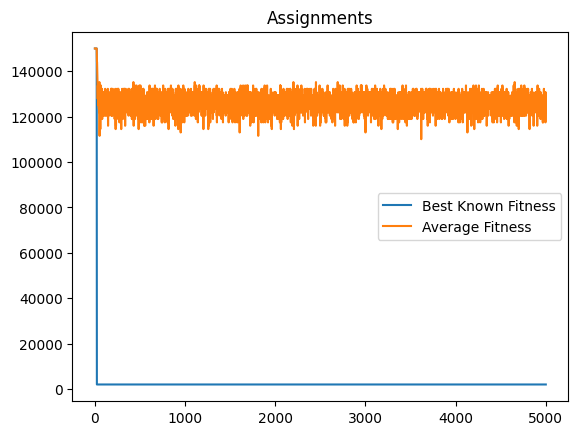

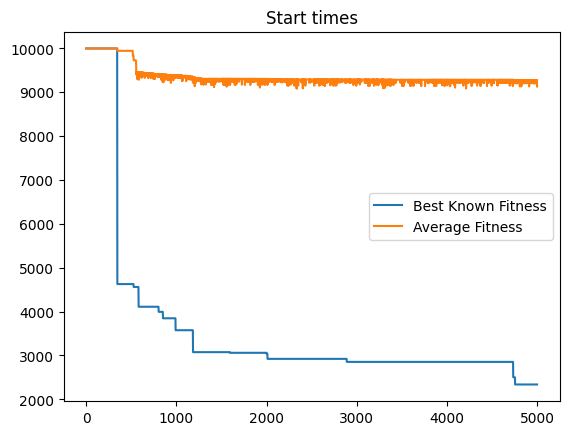

In [17]:
import matplotlib.pyplot as plt
x = list(range(0, len(assignments_best)))
plt.plot(x, assignments_best)
plt.plot(x, average_assignments)
plt.title('Assignments')
plt.legend(['Best Known Fitness', 'Average Fitness'])
plt.xlabel = 'Generation'
plt.ylabel = 'Fitness'
plt.show()

y = list(range(0, len(time_best)))
plt.plot(y, time_best)
plt.plot(y, average_time)
plt.title('Start times')
plt.legend(['Best Known Fitness', 'Average Fitness'])
plt.xlabel = 'Generation'
plt.ylabel = 'Fitness'
plt.show()

<h3>2 Stage CMA-ES</h3>

Stage 1

In [18]:
import cma
import numpy as np

def fitness_function(solution):
    bins = dict()
    sum = 0
    max_sum = 0
    for operation in list(duration_lookup_table.keys()):
        max = float('inf')
        for workstation in list(duration_lookup_table[operation].keys()):
            if duration_lookup_table[operation][workstation] > max:
                max = duration_lookup_table[operation][workstation]
        max_sum += max
    for i in range(len(solution)):
        if int(np.floor(solution[i])) not in duration_lookup_table[operations[i]]: # illegal combination
            return len(solution) * 10000 * -1
        if i not in bins:
            bins[i] = 0
        sum += duration_lookup_table[operations[i]][int(np.floor(solution[i]))] # minimize working minutes for all workstations
        #bins[i] += duration_lookup_table[operations[i]][solution[i]]
    return sum

x0 = len(assignments) * [1]
#sigma=0.5
#sigma=1
sigma=len(workstations)-1 / 2
xopt, es = cma.fmin2(fitness_function, x0, sigma, {'integer_variables': list(range(len(x0))), 'bounds': [1, len(workstations)-1]})#, {'verb_disp': 1})
int_result = [np.floor(x) for x in es.result[0]] #NOTE: the cma library truncates/rounds all values in the background itself, apparently np.floor
print(f'Result: {int_result}')

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=723788, Mon Sep 19 14:45:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 -1.500000000000000e+05 1.0e+00 5.85e+00  6e+00  6e+00 0:00.0
termination on tolfun=1e-11 (Mon Sep 19 14:45:50 2022)
final/bestever f-value = -1.500000e+05 -1.500000e+05
incumbent solution: [3.60386534 2.79403085 1.5931497  1.2794914  1.6333778  1.08893106
 2.39617779 5.9532099  ...]
std deviations: [5.79989432 5.87204481 5.8410912  5.81603911 5.80491637 5.81554866
 5.89389661 5.93820902 ...]
Result: [4.0, 2.0, 3.0, 2.0, 2.0, 4.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 3.0, 2.0, 4.0]


Stage 2

In [19]:
assignments = int_result # use result of stage 1

def is_feasible(solution):
    for i in range(len(solution)):
        start = solution[i]
        if int(np.floor(assignments[i])) not in duration_lookup_table[operations[i]]:
            return False
        end = start + duration_lookup_table[operations[i]][int(np.floor(assignments[i]))]
        if end > last_time_slot:
            return False
        if start < earliest_time_slot:
            return False
        # overlap
        same_workstation = [] # append indices of jobs running on the same workstation
        for j in range(len(assignments)):
            if int(np.floor(assignments[j])) == int(np.floor(assignments[i])) and i != j:
                same_workstation.append(j)
        for j in range(len(same_workstation)):
            other_start = solution[same_workstation[j]]
            other_end = other_start + duration_lookup_table[operations[same_workstation[j]]][int(np.floor(assignments[same_workstation[j]]))]
            if start > other_start and start < other_end:
                return False
            if end > other_start and end < other_end:
                return False
            if other_start > start and other_start < end:
                return False
            if other_end > start and other_end < end:
                return False
        # check sequence
        order = order_for_index[i]
        if i > 0:
            if order_for_index[i-1] == order: # same order
                prev_start = solution[i-1]
                prev_end = prev_start + duration_lookup_table[operations[i-1]][int(np.floor(assignments[i-1]))]
                if prev_end > start:
                    return False
    return True

def fitness_function(solution):
    fitness = 0
    if not is_feasible(solution):
        #fitness += last_time_slot
        return 2 * last_time_slot
    max = -float('inf')
    min = float('inf')
    for i in range(len(solution)):
        start = solution[i]
        end = start + duration_lookup_table[operations[i]][int(np.floor(assignments[i]))]
        if start < min:
            min = start
        if end > max:
            max = end
    fitness += abs(max - min)
    return fitness

x1 = len(assignments) * [earliest_time_slot]
#sigma=0.5
#sigma=10
sigma=(last_time_slot-earliest_time_slot)/2
xopt, es = cma.fmin2(fitness_function, x1, sigma, {'integer_variables': list(range(len(x1))), 'bounds': [earliest_time_slot, last_time_slot]})#, {'verb_disp': 1})
int_result = [np.floor(x) for x in es.result[0]] #NOTE: the cma library truncates/rounds all values in the background itself, apparently np.floor
print(f'Result: {int_result}')
#print(f'´{xopt}')
print(f'Fitness: ´{es.result[1]}')

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=658605, Mon Sep 19 14:45:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.000000000000000e+04 1.0e+00 2.35e+03  2e+03  2e+03 0:00.0
termination on tolfun=1e-11 (Mon Sep 19 14:45:50 2022)
final/bestever f-value = 1.000000e+04 1.000000e+04
incumbent solution: [ 901.84195035   21.47898812  704.48952439 1510.46303217  466.28870404
  771.32930134  496.27380753 1890.72327113 ...]
std deviations: [2375.74026763 2331.33677846 2335.65442929 2365.95966045 2344.42163772
 2304.01155167 2346.32782647 2370.3337359  ...]
Result: [946.0, 322.0, 822.0, 4261.0, 1372.0, 903.0, 1246.0, 4060.0, 2466.0, 1777.0, 1183.0, 2283.0, 1035.0, 2329.0, 2950.0]
Fitness: ´10000


In [20]:
start_times = int_result
print(assignments)
print(start_times)
data = []
for i in range(len(assignments)):
    if int(np.floor(assignments[i])) not in duration_lookup_table[operations[i]]:
        duration = 1#0
    else:
        duration = duration_lookup_table[operations[i]][int(np.floor(assignments[i]))]
    data.append([assignments[i], operations[i], start_times[i], duration])
visualize(data)

[4.0, 2.0, 3.0, 2.0, 2.0, 4.0, 5.0, 2.0, 4.0, 4.0, 4.0, 3.0, 3.0, 2.0, 4.0]
[946.0, 322.0, 822.0, 4261.0, 1372.0, 903.0, 1246.0, 4060.0, 2466.0, 1777.0, 1183.0, 2283.0, 1035.0, 2329.0, 2950.0]


Simplify Data Structure

In [21]:
last_slot = last_time_slot
first_slot = earliest_time_slot
n_workstations = len(env.workstations)
# skip resources for now
n_jobs = 0
n_recipes = len(env.recipes)

alternative_tasks = dict()
for recipe in env.recipes:
    alternative_tasks[recipe.id] = dict()
    for task in recipe.tasks:
        if task.result_resources[0][1] == 1: # pseudo resource
            if task.result_resources[0][0] not in alternative_tasks[recipe.id]:
                alternative_tasks[recipe.id][task.result_resources[0][0]] = []
            alternative_tasks[recipe.id][task.result_resources[0][0]].append(task.id)
            n_jobs += 1

job_durations = []
for i in range(n_workstations):
    job_durations.append([])
    for j in range(n_jobs):
        job_durations[i].append(env.get_duration(j, i+1)) # get duration for job (j = id) on workstation (i+1 = id, for some reason I started workstation IDs at 1)
# NOTE: many tasks can be done on workstation 6 in this dataset for some reason
#for key in alternative_tasks.keys():
#    print(alternative_tasks[key]) # in theory, the tasks should be sorted correctly to resemble the stages
# missing for now: translation of resources for resource constrained optimization


In [22]:
available_tasks = []
for recipe_id in alternative_tasks:
    for pseudo_resource in alternative_tasks[recipe_id]:
        available_tasks.append(pseudo_resource)
def job_for_index(i):
    recipe = available_tasks[orders[order_for_index[i]][0]]
    job_index = 0
    j = i
    done = False
    while j > 0 and not done:
        if order_for_index[j] == order_for_index[j-1]:
            job_index += 1
        else:
            done = True
        j -= 1
    return recipe[job_index]

assignments = []
start_times = []
j = 0
for i in range(len(solution)):
    if j == 0:
        assignments.append(solution[i])
    else:
        start_times.append(solution[i])
    j += 1
    if j > 1:
        j = 0
print(assignments)
print(start_times)
order_for_index = []
for i in range(len(orders)):
    for job in range(len(available_tasks[orders[i][0]])):
        order_for_index.append(i)
print(order_for_index)
durations = []
for i in range(len(assignments)):
    # row = workstation, col = job
    # fetch job from recipe -> get through order
    # fetch workstation from assignments list
    job = job_for_index(i)
    durations.append(job_durations[assignments[i]][job])
print(durations)

[2883, 4363, 2626, 2200, 3161, 3321, 2962, 3979]
[3861, 2129, 4115, 2959, 2177, 3428, 3596]


TypeError: object of type 'int' has no len()

In [ ]:
def is_first(jobs, index): # check if job is the first in it's order sequence
    return jobs[index][2] == 0 or order_for_index[jobs[index][2]-1] != order_for_index[jobs[index][2]]

def compress(solution):
    assignments = []
    start_times = []
    durations = []
    order_for_index = []

    for i in range(len(orders)):
        for job in range(len(available_tasks[orders[i][0]])):
            order_for_index.append(i)
    for i in range(len(assignments)):
        job = job_for_index(i)
        durations.append(job_durations[assignments[i]][job])
    j = 0
    for i in range(len(solution)):
        if j == 0:
            assignments.append(solution[i])
        else:
            start_times.append(solution[i])
        j += 1
        if j > 1:
            j = 0
    
    w = dict()
    for i in range(len(assignments)):
        if assignments[i] not in w:
            w[assignments[i]] = []
        w[assignments[i]].append([start_times[i], start_times[i]+durations[i], i])
    for workstation in w:
        w[workstation] = sorted(w[workstation], key=lambda x: x[0])
    new_solution = copy.deepcopy(start_times)
    changes_made = True
    while changes_made:
        changes_made = False
        for workstation in w:
            for i in range(len(w[workstation])):
                shift = 0
                if is_first(w[workstation], i):
                    if i == 0:
                        shift = w[workstation][i][0]
                    else:
                        shift = w[workstation][i][0] - w[workstation][i-1][1]
                else: # find end of previous job in sequence + end of job previous on the workstation -> move to closer one
                        prev_end = new_solution[w[workstation][i][2]-1] + durations[w[workstation][i][2]-1]
                        prev_shift = w[workstation][i][0] - prev_end
                        if i == 0:
                            shift = prev_shift
                        else:
                            shift = w[workstation][i][0] - w[workstation][i-1][1]
                            if prev_shift < shift:
                                shift = prev_shift
                w[workstation][i][0] -= shift
                w[workstation][i][1] -= shift
                new_solution[w[workstation][i][2]] = w[workstation][i][0]
            changes_made = changes_made or shift != 0
    result = []
    for i in range(len(new_solution)):
        result.append(assignments[i])
        result.append(new_solution[i])
    return result